# Permutation Importance with Multicollinear or Correlated Features

Author: scikit-learn.org

Article from [scikit-learn.org](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-multicollinear-py).

> Note: In this notebook, I am studying the article mentioned above. Some changes may have been made to the code during its implementation.

# Library

In [1]:
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

# Random Forest Feature Importance on Breast Cancer Data

In [2]:
data = load_breast_cancer()
data

{'data': array([[1.799e+01, 1.038e+01, 1.228e+02, ..., 2.654e-01, 4.601e-01,
         1.189e-01],
        [2.057e+01, 1.777e+01, 1.329e+02, ..., 1.860e-01, 2.750e-01,
         8.902e-02],
        [1.969e+01, 2.125e+01, 1.300e+02, ..., 2.430e-01, 3.613e-01,
         8.758e-02],
        ...,
        [1.660e+01, 2.808e+01, 1.083e+02, ..., 1.418e-01, 2.218e-01,
         7.820e-02],
        [2.060e+01, 2.933e+01, 1.401e+02, ..., 2.650e-01, 4.087e-01,
         1.240e-01],
        [7.760e+00, 2.454e+01, 4.792e+01, ..., 0.000e+00, 2.871e-01,
         7.039e-02]]),
 'target': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
        1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
        1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0

In [5]:
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
print('Accuracy on test data: {:.2f}'.format(clf.score(X_test, y_test)))

Accuracy on test data: 0.97


In [6]:
result = permutation_importance(clf, X_train, y_train, n_repeats=10, random_state=42)
perm_sorted_idx = result.importances_mean.argsort()
perm_sorted_idx

array([29, 25,  4, 19,  9, 11, 17, 28,  6, 22,  8, 23, 20, 18, 12, 16, 14,
        2,  3, 24, 15,  0, 26, 13,  5,  1, 10, 21,  7, 27])

In [7]:
tree_importance_sorted_idx = np.argsort(clf.feature_importances_)
tree_importance_sorted_idx

array([15, 18,  9,  8, 11, 14, 17, 29, 19, 16,  4, 12, 24,  5, 28,  1, 25,
       21, 10, 26,  0,  3, 13,  2, 22, 20,  6,  7, 23, 27])

In [8]:
tree_indices = np.arange(0, len(clf.feature_importances_)) + 0.5
tree_indices

array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
       11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
       22.5, 23.5, 24.5, 25.5, 26.5, 27.5, 28.5, 29.5])

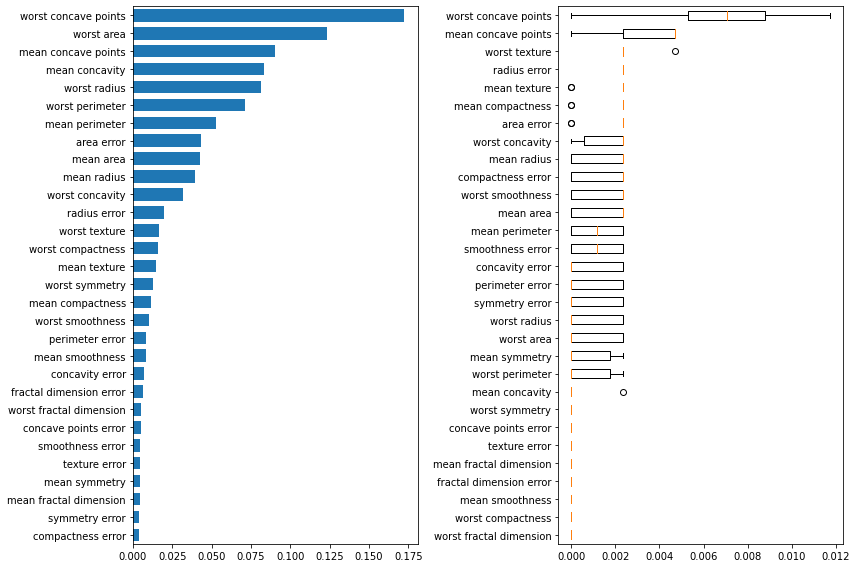

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.barh(tree_indices, clf.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticks(tree_indices)
ax1.set_yticklabels(data.feature_names[tree_importance_sorted_idx])
ax1.set_ylim((0, len(clf.feature_importances_)))
ax2.boxplot(
    result.importances[perm_sorted_idx].T,
    vert=False,
    labels=data.feature_names[perm_sorted_idx],
)
fig.tight_layout()
plt.show()

# Handling Multicollinear Features

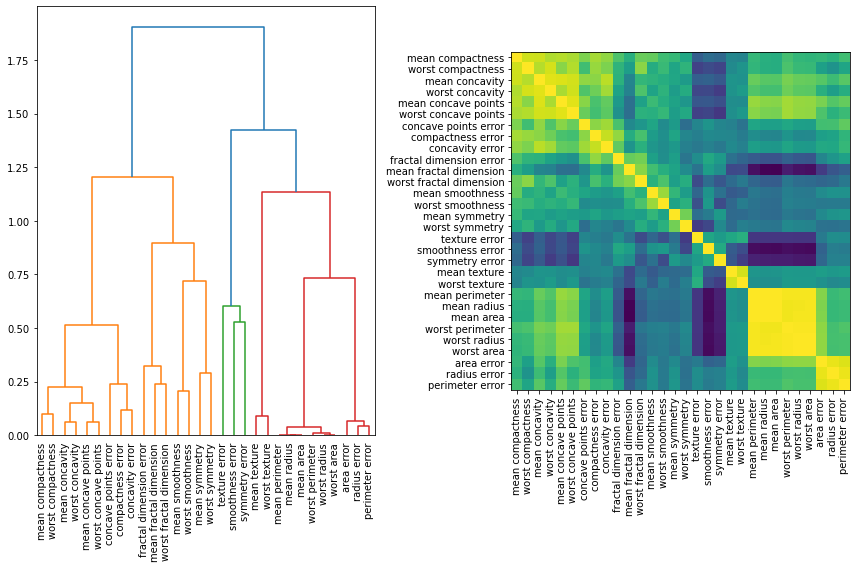

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(X).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=data.feature_names.tolist(), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro['ivl']))

ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
ax2.set_yticklabels(dendro['ivl'])
fig.tight_layout()
plt.show()

In [21]:
cluster_ids = hierarchy.fcluster(dist_linkage, 1, criterion='distance')
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]

X_train_sel = X_train[:, selected_features]
X_test_sel = X_test[:, selected_features]

clf_sel = RandomForestClassifier(n_estimators=100, random_state=42)
clf_sel.fit(X_train_sel, y_train)
print('Accuracy on test data with features removed: {:.2f}'.format(clf_sel.score(X_test_sel, y_test)))

Accuracy on test data with features removed: 0.97
